In [ ]:
# Init global infos
%load_ext tensorboard
%tensorflow_version 2.x
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras import backend as K
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np

batch_size = 50
num_classes = 10
num_train_samples = 1000

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


60000 train samples


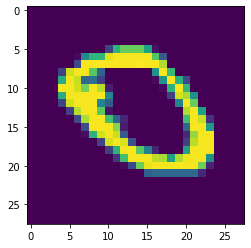

In [ ]:
def rotate_image(images, degrees):
    rot_images = []
    for image in images:
        img_rot = ndimage.rotate(image, degrees, reshape=False)
        rot_images.append(img_rot.reshape(28, 28))
    return np.array(rot_images)

# applying transformation to image
plt.imshow(x_train[1].reshape(28, 28))
img_rot = ndimage.rotate(x_train[1], 90, reshape=False)
plt.imshow(img_rot.reshape(28, 28))

x_train_rot_40 = rotate_image(x_train, 40)
x_test_rot_40 = rotate_image(x_test, 40)

x_train_rot_20 = rotate_image(x_train, 20)
x_test_rot_20 = rotate_image(x_test, 20)

x_train_rot_60 = rotate_image(x_train, 60)
x_test_rot_60 = rotate_image(x_test, 60)
    
print(x_train_rot_40.shape[0], 'train samples')

def reshapeImages(images):
    images = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
    images = images.astype('float32')
    images /= 255
    print(images.shape[0], 'samples')
    return (images)

def show_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()
    
def show_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('#f Iterations')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [ ]:
x_val = reshapeImages(x_train)[-num_train_samples:]
x_train = reshapeImages(x_train)[:-num_train_samples]
x_test = reshapeImages(x_test)

x_val_rot_40 = reshapeImages(x_train_rot_40)[-num_train_samples:]
x_train_rot_40 = reshapeImages(x_train_rot_40)[:-num_train_samples]
x_test_rot_40 = reshapeImages(x_test_rot_40)

x_val_rot_60 = reshapeImages(x_train_rot_60)[-num_train_samples:]
x_train_rot_60 = reshapeImages(x_train_rot_60)[:-num_train_samples]
x_test_rot_60 = reshapeImages(x_test_rot_60)

x_val_rot_20 = reshapeImages(x_train_rot_20)[-num_train_samples:]
x_train_rot_20 = reshapeImages(x_train_rot_20)[:-num_train_samples]
x_test_rot_20 = reshapeImages(x_test_rot_20)

# convert class vectors to binary class matrices
y_val = keras.utils.to_categorical(y_train, num_classes)[-num_train_samples:]
y_train = keras.utils.to_categorical(y_train, num_classes)[:-num_train_samples]
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 samples
60000 samples
10000 samples
60000 samples
60000 samples
10000 samples
60000 samples
60000 samples
10000 samples
60000 samples
60000 samples
10000 samples


In [ ]:
x_train.shape

(59000, 784)

In [ ]:
y_train_ones = np.ones((y_train.shape[0],1))
y_train_ = np.hstack((y_train, y_train_ones))
y_train_rot_zeros = np.zeros((y_train.shape[0],1))
y_train_rot_ = np.hstack((y_train, y_train_rot_zeros))

In [ ]:
input1 = keras.layers.Input(shape=(784, ))
dense1 = keras.layers.Dense(128, activation='relu')(input1)
dense2 = keras.layers.Dense(128, activation='relu')(dense1)
dense3 = keras.layers.Dense(20, activation='relu')(dense2)
output = keras.layers.Dense(num_classes, activation='softmax')(dense3)

model = keras.Model(inputs=input1, outputs=[dense3,output])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 20)                2580      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                210       
Total params: 119,782
Trainable params: 119,782
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Instantiate an optimizer to train the model.
optimizer = tf.compat.v1.train.AdamOptimizer()
# Instantiate a loss function.
loss_cc = keras.losses.CategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()

# Prepare the training datasets
train_dataset = tf.data.Dataset.from_tensor_slices((np.concatenate([x_train, x_train_rot_40], axis=0), np.concatenate([y_train_,y_train_rot_],axis=0)))
train_dataset = train_dataset.shuffle(buffer_size=200000).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [ ]:
def distance_loss(predictions, y, predictions_target, y_target, classes_y):
    def some_function(tensor):
      y_source = tensor[1]
      equal =  tf.math.equal(y_source, y_target)
      equal_all = tf.reduce_all(equal, axis=1)
      contains = tf.boolean_mask(predictions_target, equal_all)
      # manhattan distance
      distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(tensor[0], contains)), axis=1))
      # nearest k points
      closest_distance,_ = tf.math.top_k(tf.negative(distance), k=1)
      return tf.abs(closest_distance)
    y_equal_source =  tf.math.equal(classes_y, tf.constant(1, dtype=tf.float32))
    y_equal_all_source = tf.reduce_all(y_equal_source, axis=1)
    predictions_source = tf.boolean_mask(predictions, y_equal_all_source)
    y_source = tf.boolean_mask(y, y_equal_all_source)
    d = tf.map_fn(some_function, (predictions_source,y_source), dtype=tf.float32)
    return tf.math.reduce_sum(d)

In [ ]:
def train_step(model, optimizer, x_batch, y_batch, x_train_target, y_train_target, classes_y):

    with tf.GradientTape() as tape:   
      hidden_logits = model(x_batch, training=True)[0]
      hidden_logits_target = model(x_train_target, training=True)[0]
      loss_dist = distance_loss(hidden_logits, y_batch, hidden_logits_target, y_train_target, classes_y)
      logits = model(x_batch, training=True)[1]
      loss_cross = loss_cc(y_batch, logits)
      loss_value = loss_cross + 0.001*loss_dist

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Update training metric.
    train_acc_metric(y_batch, logits)
    return loss_value, loss_dist, loss_cross

In [ ]:
dist_losses = []
train_accuracy = []
cross_entropy_losses = []
val_accuracy = []
num_epochs = 10

for epoch in range(num_epochs):
    print('Start of epoch %d' % (epoch,))
    # Iterate over the batches of the dataset.
    step = 0

    for (x_batch, y_batch) in train_dataset:
      
      classes_y = tf.cast(tf.strided_slice(tf.identity(y_batch), [0,-1], [y_batch.shape[0],y_batch.shape[0]], [1,1]),dtype=tf.float32)
      y_batch_ = tf.cast(tf.strided_slice(tf.identity(y_batch), [0,0], [y_batch.shape[0],-1], [1,1]),dtype=tf.float32)

      loss_value, loss_dist, loss_cross = train_step(model, optimizer, x_batch, y_batch_, tf.constant(x_train_rot_40, dtype=tf.float32), tf.constant(y_train, dtype=tf.float32), classes_y)

      # Log every 250 batches.
      if step % 250 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Distance loss and cross entropy loss at step %s: %s  %s' % (step, float(loss_dist),float(loss_cross)))

      step +=1
    
    dist_losses.append(float(loss_dist))
    cross_entropy_losses.append(float(loss_cross))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %s' % (float(train_acc),))
    train_accuracy.append(float(train_acc))

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val)[1]
        # Update val metrics
        val_acc_metric(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    print('Validation acc: %s' % (float(val_acc),))
    val_accuracy.append(float(val_acc))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Start of epoch 0
Training loss (for one batch) at step 0: 2.3143692016601562
Distance loss and cross entropy loss at step 0: 6.868419647216797  2.3075008392333984
Training loss (for one batch) at step 250: 1.7017552852630615
Distance loss and cross entropy loss at step 250: 30.480106353759766  1.6712751388549805
Training loss (for one batch) at step 500: 1.6149909496307373
Distance loss and cross entropy loss at step 500: 21.06720733642578  1.5939236879348755
Training loss (for one batch) at step 750: 1.5984216928482056
Distance loss and cross entropy loss at step 750: 29.25707244873047  1.5691646337509155
Training loss (for one batch) at step 1000: 1.5944342613220215
Distance loss and cross entropy loss at step 1000: 22.97894859313965  1.5714553594589233
Training loss (for one batch) at step 1250: 1.6060231924057007
Distance loss and cross entropy loss at step 1250: 19.64965057373047  1.5863735675811768
Training loss (for one batch) at step 1500: 1.5383647680282593
Distance loss and c

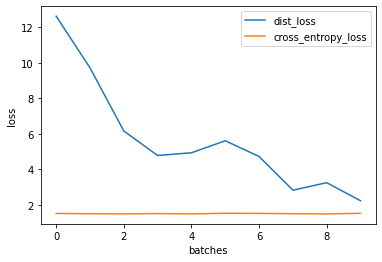

In [ ]:
plt.plot(dist_losses)
plt.plot(cross_entropy_losses)
plt.ylabel('loss')
plt.xlabel('batches')
plt.legend(['dist_loss', 'cross_entropy_loss'], loc='best')
plt.show()

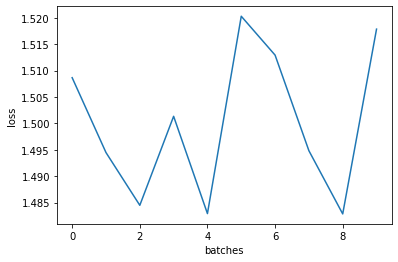

In [ ]:
plt.plot(cross_entropy_losses)
plt.ylabel('loss')
plt.xlabel('batches')
plt.show()

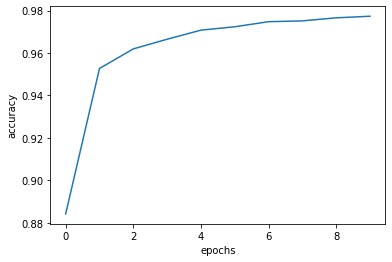

In [ ]:
plt.plot(train_accuracy)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

In [ ]:
model_new = keras.models.clone_model(model)
model_new.set_weights(model.get_weights()) 

model_new._layers.pop()
for layer in model_new.layers: layer.trainable = False  

# recover the output from the last layer in the model and use as input to new Dense layer
last = model_new.layers[-1].output
output = keras.layers.Dense(num_classes, activation="softmax", name="output")(last)
model_new = keras.models.Model(model_new.input, output)

for layer in model_new.layers:
    print(layer, layer.trainable)

model_new.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model_new.summary()

history = model_new.fit(np.concatenate([x_train, x_train_rot_40], axis=0), np.concatenate([y_train,y_train],axis=0), validation_data = (x_val, y_val), epochs=10,
    shuffle=True,
    verbose=1)

score = model_new.evaluate(x_test_rot_60, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f85d9450400> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f85d5ff9c18> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f85d7200748> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f85d7266d68> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f85d93778d0> True
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 20)                2580      
___

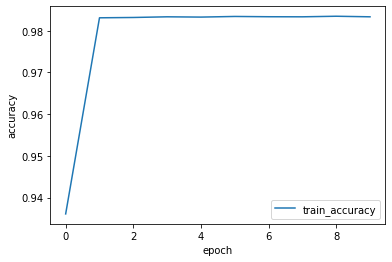

In [ ]:
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy'], loc='best')
plt.show()